In [ ]:
import sys
from pathlib import Path

# Find project root by looking for .git or requirements.txt
current = Path.cwd()
while not any((current / marker).exists() for marker in ['.git', 'requirements.txt']):
    if current.parent == current:
        raise FileNotFoundError("Project root not found")
    current = current.parent

sys.path.append(str(current))
print(f"Added project root: {current}")

In [4]:
! pip install git+https://github.com/nicola-decao/power_spherical.git

  Cloning https://github.com/nicola-decao/power_spherical.git to /tmp/pip-req-build-hgicux5b
  Running command git clone --filter=blob:none --quiet https://github.com/nicola-decao/power_spherical.git /tmp/pip-req-build-hgicux5b
  Resolved https://github.com/nicola-decao/power_spherical.git to commit 3d4619a9d6c01bc9b427533d386271a233e304cd
  Preparing metadata (setup.py) ... done


In [5]:
! pip install -U lightning

In [6]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using {device} device")

Using cuda device


In [7]:
# ! tensorboard --logdir . --bind_all

# Loading datasets

In [8]:
from matplotlib import pyplot as plt
import numpy as np
import h5py
import requests
import os
import random
import torch

In [9]:
def download_file(url, filename, force_download=False, stream=True):
    """
    Downloads a file from a specified URL.

    :param url: URL of the file to download.
    :param filename: Local filename to save the downloaded file.
    :param force_download: If True, forces the download even if the file already exists.
    :param stream: If True, downloads the file in chunks to save memory.
    """
    
    # Check if the file already exists
    if os.path.exists(filename) and not force_download:
        print(f"File '{filename}' already exists.")
        return
    
    # Send a GET request to the specified URL
    response = requests.get(url, stream=stream)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Open the file in write-binary mode
        with open(filename, 'wb') as file:
            if stream:
                # Write the content of the response to the file in chunks
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        file.write(chunk)
            else:
                # Write the full content at once
                file.write(response.content)
                
        print(f"File '{filename}' downloaded successfully.")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

In [10]:
# plot some images

def plot_images(images, n_images, randomize):
    if randomize:
        selected_images = random.sample(range(len(images)), n_images)
    else:
        selected_images = range(n_images)
    
    fig, axes = plt.subplots(1, n_images, figsize=(n_images, 1))
    for i, image_idx in enumerate(selected_images):
        axes[i].imshow(images[image_idx])
        axes[i].axis('off')
    plt.show()

## 3dshapes dataset

In [11]:
# https://github.com/google-deepmind/3d-shapes

dataset_url = 'https://storage.googleapis.com/3d-shapes/3dshapes.h5'
dataset_filename = '3dshapes.h5'

download_file(dataset_url, dataset_filename)

File '3dshapes.h5' already exists.


In [12]:

# load dataset
dataset = h5py.File('3dshapes.h5', 'r')
print(dataset.keys())
images = dataset['images']  # array shape [480000,64,64,3], uint8 in range(256)
labels = dataset['labels']  # array shape [480000,6], float64
image_shape = images.shape[1:]  # [64,64,3]
label_shape = labels.shape[1:]  # [6]
n_samples = labels.shape[0]  # 10*10*10*8*4*15=480000

_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape',
                     'orientation']

_NUM_VALUES_PER_FACTOR = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 
                          'scale': 8, 'shape': 4, 'orientation': 15}

print(f"image shape: {image_shape}, label shape: {label_shape}, n_samples: {n_samples}")

<KeysViewHDF5 ['images', 'labels']>
image shape: (64, 64, 3), label shape: (6,), n_samples: 480000


In [13]:
labels = np.array(labels)

In [14]:
images[0], labels[100]

(array([[[153, 226, 249],
         [153, 226, 249],
         [153, 226, 249],
         ...,
         [153, 226, 249],
         [153, 226, 249],
         [153, 226, 249]],
 
        [[153, 226, 249],
         [153, 226, 249],
         [153, 226, 249],
         ...,
         [153, 226, 249],
         [153, 226, 249],
         [153, 226, 249]],
 
        [[153, 226, 249],
         [153, 226, 249],
         [153, 226, 249],
         ...,
         [153, 226, 249],
         [153, 226, 249],
         [153, 226, 249]],
 
        ...,
 
        [[255,   0,   0],
         [255,   0,   0],
         [255,   0,   0],
         ...,
         [235,   0,   0],
         [237,   0,   0],
         [236,   0,   0]],
 
        [[255,   0,   0],
         [255,   0,   0],
         [255,   0,   0],
         ...,
         [230,   0,   0],
         [225,   0,   0],
         [231,   0,   0]],
 
        [[255,   0,   0],
         [255,   0,   0],
         [255,   0,   0],
         ...,
         [230,   0,   0],
  

In [15]:
# print each factor and crossponding values

for i, factor_name in enumerate(_FACTORS_IN_ORDER):
    num_values = _NUM_VALUES_PER_FACTOR[factor_name]
    factor_values = labels[:, i]
    unique_values = np.unique(factor_values)
    print(f'{i}: {factor_name} (num_values={num_values}) \n values={unique_values}')

0: floor_hue (num_values=10) 
 values=[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
1: wall_hue (num_values=10) 
 values=[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
2: object_hue (num_values=10) 
 values=[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
3: scale (num_values=8) 
 values=[0.75       0.82142857 0.89285714 0.96428571 1.03571429 1.10714286
 1.17857143 1.25      ]
4: shape (num_values=4) 
 values=[0. 1. 2. 3.]
5: orientation (num_values=15) 
 values=[-30.         -25.71428571 -21.42857143 -17.14285714 -12.85714286
  -8.57142857  -4.28571429   0.           4.28571429   8.57142857
  12.85714286  17.14285714  21.42857143  25.71428571  30.        ]


In [16]:
labels[:,3] = labels[:,3] - 0.75
np.unique(labels[:,3])

array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       ])

In [17]:
print(f"image shape: {images[0].shape}, label shape: {labels[0].shape}, n_samples: {n_samples}")

image shape: (64, 64, 3), label shape: (6,), n_samples: 480000


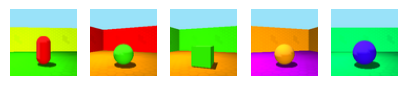

In [18]:
plot_images(images, n_images=5, randomize=True)

In [19]:
def get_image_indices(selected_factors):
    not_selected_factors = [key for key in _FACTORS_IN_ORDER if key not in selected_factors]

    print(f"not selected factors: {not_selected_factors}")
    
    selected_sample_indices = np.ones(n_samples, dtype=bool)

    for not_selected_factor in not_selected_factors:
        selected_sample_indices &= labels[:, _FACTORS_IN_ORDER.index(not_selected_factor)] == 0
    
    selected_sample_indices = np.where(selected_sample_indices)[0] # get indices of True values
    
    return selected_sample_indices

In [20]:
# select a subset of images based the chosen ground truth factors (based on the names of the factors)
selected_factors = ["floor_hue", "wall_hue", "shape", "object_hue"]
selected_factor_indices = [i for i, factor in enumerate(_FACTORS_IN_ORDER) if factor in selected_factors]

In [21]:
selected_images_3dsShapes_indices = get_image_indices(selected_factors)
# print(f"Number of images selected: {selected_images_3dsShapes_indices.sum()}")
print(f"Number of images selected: {len(selected_images_3dsShapes_indices)}")

selected_images_3dsShapes = images[selected_images_3dsShapes_indices]

not selected factors: ['scale', 'orientation']
Number of images selected: 4000


In [22]:
# convert it to tensor make it first channel
# selected_images_3dsShapes_tensor = torch.tensor(selected_images_3dsShapes).permute(0, 3, 1, 2).float()
selected_images_3dsShapes_tensor = torch.tensor(selected_images_3dsShapes).permute(0, 3, 1, 2).float() / 255.0

print(f"Shape of the selected images tensor: {selected_images_3dsShapes_tensor.shape}")

Shape of the selected images tensor: torch.Size([4000, 3, 64, 64])


In [23]:
selected_images_3dsShapes_labels_tensor = torch.tensor(labels[selected_images_3dsShapes_indices])
selected_images_3dsShapes_labels_tensor = selected_images_3dsShapes_labels_tensor[:, selected_factor_indices]

print(f"Shape of the selected labels tensor: {selected_images_3dsShapes_labels_tensor.shape}")

Shape of the selected labels tensor: torch.Size([4000, 4])


In [24]:
import torch

# Assuming selected_images_3dsShapes_tensor is your tensor
tensor = selected_images_3dsShapes_tensor

# Calculate the range
tensor_min = tensor.min()
tensor_max = tensor.max()
tensor_range = tensor_max - tensor_min

print(f"Min value: {tensor_min}")
print(f"Max value: {tensor_max}")
print(f"Range: {tensor_range}")

Min value: 0.0
Max value: 1.0
Range: 1.0


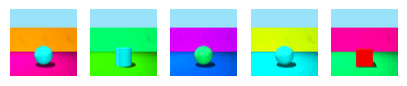

In [25]:
plot_images(selected_images_3dsShapes, n_images=5, randomize=True)

# dsprites-dataset

In [26]:
dataset_filename = 'dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
dSprites_dataset = np.load(dataset_filename, encoding='bytes', allow_pickle=True)
dSprites_dataset

NpzFile 'dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz' with keys: metadata, imgs, latents_classes, latents_values

In [27]:
dSprites_factors = ["color", "shape", "scale", "orientation", "posX", "posY"]

In [28]:
# dsprites metadata
print(dSprites_dataset['metadata'])

{b'date': b'April 2017', b'description': b'Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6 disentangled latent factors.This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite. All possible variations of the latents are present. Ordering along dimension 1 is fixed and can be mapped back to the exact latent values that generated that image.We made sure that the pixel outputs are different. No noise added.', b'version': 1, b'latents_names': (b'color', b'shape', b'scale', b'orientation', b'posX', b'posY'), b'latents_possible_values': {b'orientation': array([0.        , 0.16110732, 0.32221463, 0.48332195, 0.64442926,
       0.80553658, 0.96664389, 1.12775121, 1.28885852, 1.44996584,
       1.61107316, 1.77218047, 1.93328779, 2.0943951 , 2.25550242,
       2.41660973, 2.57771705, 2.73882436, 2.89993168, 3.061039  ,
       3.22214631, 3.38325363, 3.54436094, 3.70546826, 3.86657557,
       4.02768289, 4.1887902 , 4.34989

In [29]:
dSprites_images = dSprites_dataset['imgs']
dSprites_latents_classes = dSprites_dataset['latents_classes']
dSprites_latents_values = dSprites_dataset['latents_values']

In [30]:
print(dSprites_images.shape, dSprites_latents_classes.shape, dSprites_latents_values.shape)
print(dSprites_latents_classes)

(737280, 64, 64) (737280, 6) (737280, 6)
[[ 0  0  0  0  0  0]
 [ 0  0  0  0  0  1]
 [ 0  0  0  0  0  2]
 ...
 [ 0  2  5 39 31 29]
 [ 0  2  5 39 31 30]
 [ 0  2  5 39 31 31]]


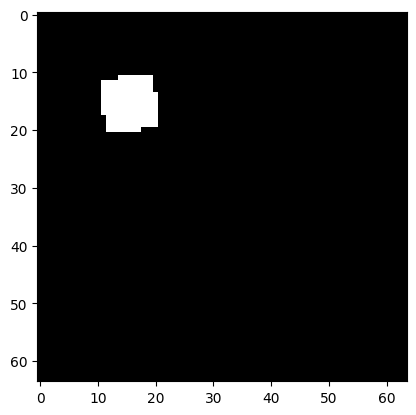

In [31]:
plt.imshow(dSprites_images[1024], cmap='gray')

In [32]:
dSprites_selected_factors = ["color", "shape", "orientation", 'posX', 'posY']

In [33]:
def get_dSprites_image_indices(selected_factors):
    not_selected_factors = [factor for factor in dSprites_factors if factor not in selected_factors]

    print(f"not selected factors: {not_selected_factors}")
    
    selected_sample_indices = np.ones(dSprites_images.shape[0], dtype=bool)

    for not_selected_factor in not_selected_factors:
        selected_sample_indices &= dSprites_latents_classes[:, dSprites_factors.index(not_selected_factor)] == 0
    
    selected_sample_indices = np.where(selected_sample_indices)[0] # get indices of True values
    
    return selected_sample_indices

In [34]:
sampled_dSprites_indices = get_dSprites_image_indices(dSprites_selected_factors)

not selected factors: ['scale']


In [35]:
sampled_dSprites_indices.shape

(122880,)

In [36]:
selected_dSprites_images = dSprites_images[sampled_dSprites_indices]
selected_dSprites_latents_values = dSprites_latents_values[sampled_dSprites_indices]

print(f"Shape of the selected dSprites images: {selected_dSprites_images.shape}, shape of the selected dSprites latents values: {selected_dSprites_latents_values.shape}")

Shape of the selected dSprites images: (122880, 64, 64), shape of the selected dSprites latents values: (122880, 6)


In [37]:
selected_dSprites_images = torch.tensor(selected_dSprites_images).unsqueeze(1).float()
selected_dSprites_latents_values = torch.tensor(selected_dSprites_latents_values)

print(f"Shape of the selected dSprites images: {selected_dSprites_images.shape}, shape of the selected dSprites latents values: {selected_dSprites_latents_values.shape}")

Shape of the selected dSprites images: torch.Size([122880, 1, 64, 64]), shape of the selected dSprites latents values: torch.Size([122880, 6])


# Dataset utils

In [38]:
class DatasetTensor(torch.utils.data.Dataset):
    def __init__(self, images_tensor, labels_tensor):
        self.images = images_tensor
        self.labels = labels_tensor

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [39]:
def random_sample_data(data, n_samples):
    n_data = len(data)
    indices = random.sample(range(n_data), n_samples)
    sampled =  [data[i] for i in indices]
    # make it tensor
    sampled = torch.stack(sampled)
    return sampled

# Plot functions

In [40]:
import torch
import torchvision
import matplotlib.pyplot as plt

def plot_tensor_grid(title, tensor, n_cols=5, figsize=(10, 10), show_axis=False):
    """
    Plots a tensor of images in a grid.

    Parameters:
    - tensor (torch.Tensor): The input tensor of size [N, C, H, W], where
                             N is the number of images,
                             C is the number of channels,
                             H is the height, and
                             W is the width.
    - nrow (int): Number of images per row in the grid.
    - figsize (tuple): Size of the figure for plotting.
    - show_axis (bool): Whether to show axes in the plot.
    """
    # Normalize each image in the tensor individually
    tensor = tensor.clone().cpu()  # Clone to avoid modifying the original tensor

    for i in range(tensor.size(0)):
        img = tensor[i]
        img_min = img.min()
        img_max = img.max()
        tensor[i] = (img - img_min) / (img_max - img_min)  # Normalize to [0, 1]
    
    # Use torchvision's make_grid to create a grid of images
    # nrows specify the number of images per row
    grid_img = torchvision.utils.make_grid(tensor, nrow=n_cols)

    # Convert the grid to a numpy array
    np_grid = grid_img.permute(1, 2, 0).numpy()

    # Plot the grid
    plt.figure(figsize=figsize)
    plt.imshow(np_grid)
    if not show_axis:
        plt.axis('off')  # Remove axes for better visualization
    
    plt.title(title)
    plt.show()

# S-VAE

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader

from power_spherical import HypersphericalUniform, PowerSpherical

In [42]:
# Encoder network
class Encoder(nn.Module):
    def __init__(self, input_channels_num, output_dim):
        super(Encoder, self).__init__()
        
        self.encode = nn.Sequential(
            nn.Conv2d(input_channels_num, 32, 4, stride=2, padding=1),  # 64x64xinput_channels -> 32x32x32
            nn.ReLU(),
            nn.Conv2d(32, 32, 4, stride=2, padding=1),  # 32x32x32 -> 16x16x32
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 16x16x64 -> 8x8x64
            nn.ReLU(),
            nn.Conv2d(64, 64, 4, stride=2, padding=1),  # 8x8x64 -> 4x4x64
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4 * 4 * 64, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)  # mu and logvar output
        )
    
    def forward(self, x):
        return self.encode(x)

In [43]:
# Decoder network
class Decoder(nn.Module):
    def __init__(self, input_dim, output_channels_num, normalize_decoder):
        super(Decoder, self).__init__()
        
        # VAE Decoder
        self.decode = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 4 * 4 * 64),
            nn.ReLU(),
            nn.Unflatten(1, (64, 4, 4)),
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1),  # 4x4x64 -> 8x8x64
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 8x8x64 -> 16x16x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 4, stride=2, padding=1),  # 16x16x32 -> 32x32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, output_channels_num, 4, stride=2, padding=1),   # 32x32x32 -> 64x64xoutput_channels
            nn.Sigmoid() if normalize_decoder else nn.Identity()
        )
    
    def forward(self, z):
        return self.decode(z)

In [62]:
class S_VAE(pl.LightningModule):
    def __init__(self, latent_dim, encoder_input_channels_num, decoder_output_channels_num, lr, kl_loss_weight, recon_loss_type, recon_loss_reduction, normalize_decoder):
        super(S_VAE, self).__init__()
        self.save_hyperparameters()

        self.encoder = Encoder(encoder_input_channels_num, latent_dim * 2)
        self.decoder = Decoder(latent_dim, decoder_output_channels_num, normalize_decoder)
        
        self.mu_network = nn.Linear(latent_dim * 2, latent_dim) # Convert the output to mu in vmf distribution
        self.kappa_network = nn.Linear(latent_dim * 2, 1) # Convert the output to kappa in vmf distribution
    
    
    def reparametrize(self, mu, kappa):
        q_z_x = PowerSpherical(mu, kappa) # Create a powerspherical distribution, this module go to the same device as mu based in the class definition
        p_z = HypersphericalUniform(self.hparams.latent_dim - 1, device=mu.device)
        q_z_x_sample = q_z_x.rsample() # Sample from the vmf distribution

        return q_z_x, p_z, q_z_x_sample
    
    def forward(self, x):
        
        z = self.encoder(x)

        mu = self.mu_network(z)
        mu = mu / mu.norm(dim=-1, keepdim=True) # Normalize mu to have unit norm for vmf distribution because mu is on the unit hypersphere

        kappa = self.kappa_network(z)
        kappa.squeeze_(-1) # Remove the last dimension
        
        kappa = F.softplus(kappa) + 1 # Ensure that kappa is positive
        

        # reparemetrization trick
        q_z_x, p_z, q_z_x_sample = self.reparametrize(mu, kappa)

        # print(f"mu: {mu.shape}, kappa: {kappa.shape}, q_z_x_sample: {q_z_x_sample.shape}")
        
        # Decode the latent representation to get the reconstructed image
        x_recon = self.decoder(q_z_x_sample)
        
        return x_recon, q_z_x, p_z ,q_z_x_sample

    def reconstruction_loss(self, x_reconstructed, x, type, reduction):
    # TODO Implement how we reduce the reconstruction loss

        assert type in ["bce", "mse"], "Reconstruction loss type must be either 'bce' or 'mse'"
        assert reduction in ["batchmean", "pixelmean"], "Reduction type must be either 'batchmean' or 'pixelmean'"
        assert x_reconstructed.shape == x.shape, "The shapes of the reconstructed and original input must match"

        if type == "bce":
            # Reconstruction loss: BCE between the reconstructed input and the original input.

            assert self.hparams.normalize_decoder, "The decoder output must be normalized to [0, 1] for BCE loss"

            if reduction == "batchmean":
                return F.binary_cross_entropy(x_reconstructed, x, reduction='sum').div(x.size(0))
            elif reduction == "pixelmean":
                return F.binary_cross_entropy(x_reconstructed, x, reduction='mean')
        
        elif type == "mse":
            if reduction == "batchmean":
                return F.mse_loss(x_reconstructed, x, reduction='sum').div(x.size(0))
            elif reduction == "pixelmean":
                return F.mse_loss(x_reconstructed, x, reduction='mean')
        
    
    def loss(self, x, x_recon, q_z_x, p_z):
        # Reconstruction loss
        # recon_loss = F.mse_loss(x_recon, x, reduction='sum').div(x.size(0)) # MSE loss for image reconstruction (normalized by the batch size)
        # recon_loss = F.mse_loss(x_recon, x, reduction='sum')
        # recon_loss = F.mse_loss(x_recon, x, reduction='mean')
        recon_loss = self.reconstruction_loss(x_recon, x, type=self.hparams.recon_loss_type, reduction=self.hparams.recon_loss_reduction)
        
        # KL divergence
        kl_div = torch.distributions.kl.kl_divergence(q_z_x, p_z).mean() # KL divergence between the variational and prior distributions
        
        total_loss = recon_loss + self.hparams.kl_loss_weight * kl_div
        
        return total_loss, recon_loss, kl_div
    
    def generate_samples(self, n_samples, device):
        p_z = HypersphericalUniform(self.hparams.latent_dim, device=device)
        latent_samples_shape = torch.Size([n_samples])
        
        self.decoder.to(device)
        self.decoder.eval()

        with torch.no_grad():
            z = p_z.sample(latent_samples_shape).to(device)

            print(f"z: {z.shape}")

            samples = self.decoder(z)
        
        self.decoder.train()
        self.decoder.to(self.device)
        return samples
    
    def reconstructed_samples(self, x, device):

        self.decoder.to(device)
        self.decoder.eval()

        with torch.no_grad():
            x_recon, _, _, _ = self(x)
        
        self.decoder.train()
        self.decoder.to(self.device)

        return x_recon
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
    
    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_recon, q_z_x, p_z ,q_z_x_sample = self(x)
        loss, recon_loss, kl_div = self.loss(x, x_recon, q_z_x, p_z)

        metric_dict = {'train_loss': loss, 'recon_loss': recon_loss, 'kl_div': kl_div}
        self.log_dict(metric_dict, on_epoch=True, prog_bar=True, on_step=False)

        # print(f"Epoch: {self.current_epoch}, Batch: {batch_idx}, Loss: {loss.item()}, Recon Loss: {recon_loss.item()}, KL Div: {kl_div.item()}")

        return loss

# 3D Shapes dataset

In [84]:
# hyperparameters
latent_dim = 10
lr = 1e-4
kl_loss_weight = 1
batch_size = 64
epochs = 500
encoder_input_channels_num = 3
decoder_output_channels_num = 3

recon_loss_type = "mse"
recon_loss_reduction = "batchmean"
normalize_decoder = False

In [85]:
s_vae_model = S_VAE(latent_dim=latent_dim,
                    encoder_input_channels_num=encoder_input_channels_num,
                    decoder_output_channels_num=decoder_output_channels_num,
                    lr=lr,
                    kl_loss_weight=kl_loss_weight,
                    recon_loss_type=recon_loss_type,
                    recon_loss_reduction=recon_loss_reduction,
                    normalize_decoder=normalize_decoder)

In [86]:
logger = TensorBoardLogger("lightning_logs", name="s-vae-3dShapes")

In [87]:
trainer = pl.Trainer(max_epochs=epochs, enable_progress_bar=True, logger=logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [88]:
shape_3d_dataset = DatasetTensor(selected_images_3dsShapes_tensor, selected_images_3dsShapes_labels_tensor)
train_dataloader = DataLoader(shape_3d_dataset, batch_size=batch_size, shuffle=True, num_workers=7, pin_memory=True, persistent_workers=True)

In [89]:
trainer.fit(s_vae_model, train_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type    | Params | Mode 
--------------------------------------------------
0 | encoder       | Encoder | 383 K  | train
1 | decoder       | Decoder | 382 K  | train
2 | mu_network    | Linear  | 210    | train
3 | kappa_network | Linear  | 21     | train
--------------------------------------------------
766 K     Trainable params
0         Non-trainable params
766 K     Total params
3.066     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


z: torch.Size([32, 10])


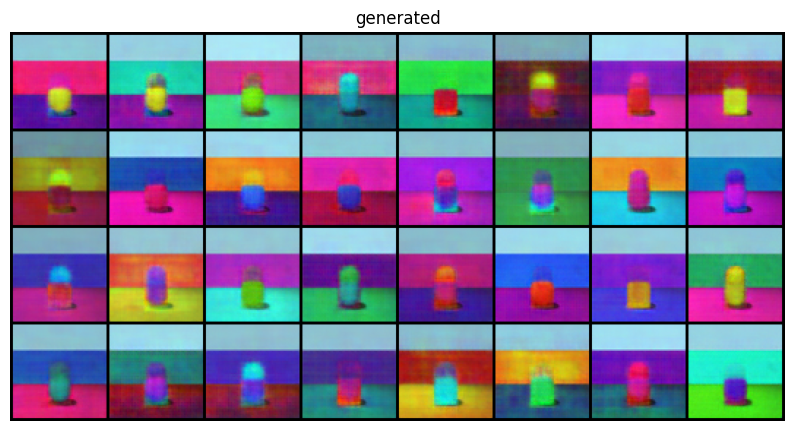

In [97]:
generated_samples = s_vae_model.generate_samples(n_samples=32, device=device).cpu()
plot_tensor_grid("generated",generated_samples, n_cols=8, figsize=(10, 10), show_axis=False)

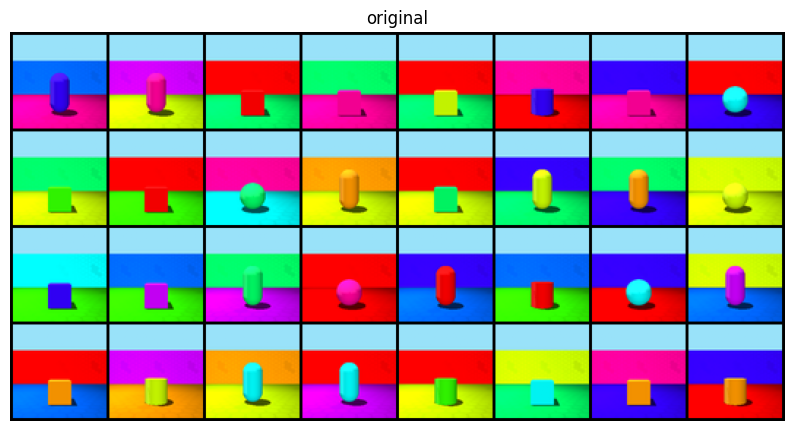

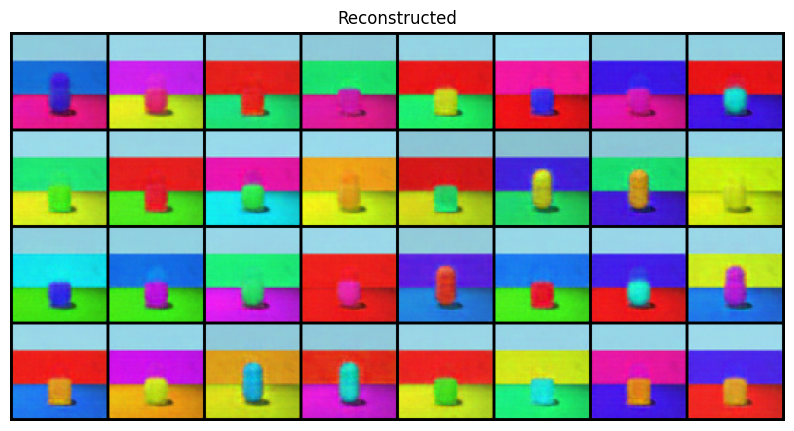

In [99]:
random_samples = random_sample_data(selected_images_3dsShapes_tensor, n_samples=32).cpu()
reconstructed_samples = s_vae_model.reconstructed_samples(random_samples, device='cpu').cpu()


plot_tensor_grid("original", random_samples,  n_cols=8, figsize=(10, 10), show_axis=False)
plot_tensor_grid("Reconstructed", reconstructed_samples, n_cols=8, figsize=(10, 10), show_axis=False)

In [78]:
! tensorboard --logdir lightning_logs --bind_all

2024-10-07 16:41:32.180608: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 16:41:32.180660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 16:41:32.181737: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 16:41:32.187535: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 16:41:32.863264: W tensorflow/compiler/tf2

# dsprites-dataset

In [42]:
# hyperparameters
latent_dim = 10
encoder_input_channels_num = 1
decoder_output_channels_num = 1
lr = 1e-4
kl_loss_weight = 1
batch_size = 64
epochs = 200

recon_loss_type = "bce"
recon_loss_reduction = "batchmean"
normalize_decoder = True

In [43]:
dSprites_dataset = DatasetTensor(selected_dSprites_images, selected_dSprites_latents_values)
train_dataloader = DataLoader(dSprites_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=7, persistent_workers=True)

In [44]:
s_vae_model = S_VAE(latent_dim=latent_dim,
                    encoder_input_channels_num=encoder_input_channels_num,
                    decoder_output_channels_num=decoder_output_channels_num,
                    lr=lr,
                    kl_loss_weight=kl_loss_weight,
                    recon_loss_type=recon_loss_type,
                    recon_loss_reduction=recon_loss_reduction,
                    normalize_decoder=normalize_decoder)

In [45]:
logger = TensorBoardLogger("lightning_logs", name="s-vae-dSprites")

In [46]:
trainer = pl.Trainer(max_epochs=epochs, enable_progress_bar=True, logger=logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [47]:
trainer.fit(s_vae_model, train_dataloader)

You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-10-07 17:05:44.335106: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 17:05:44.335161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 17:05:44.337334: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/distributions/distribution.py:53: UserWarning: <class 'hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=200` reached.


z: torch.Size([32, 10])


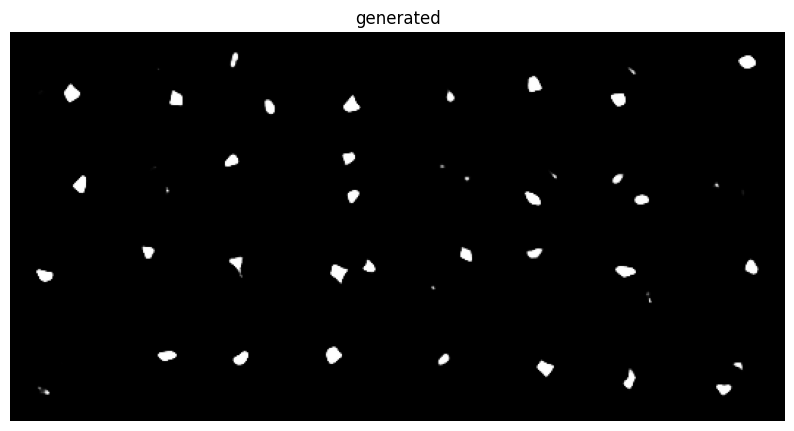

In [169]:
generated_samples = s_vae_model.generate_samples(n_samples=32, device=device).cpu()
plot_tensor_grid("generated",generated_samples, n_cols=8, figsize=(10, 10), show_axis=False)

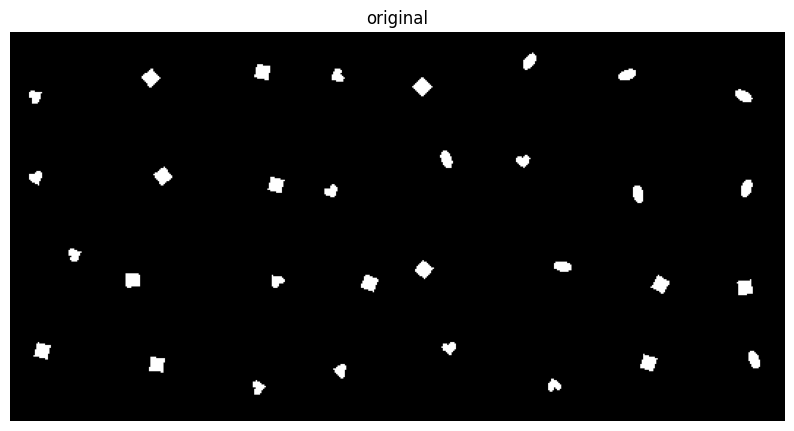

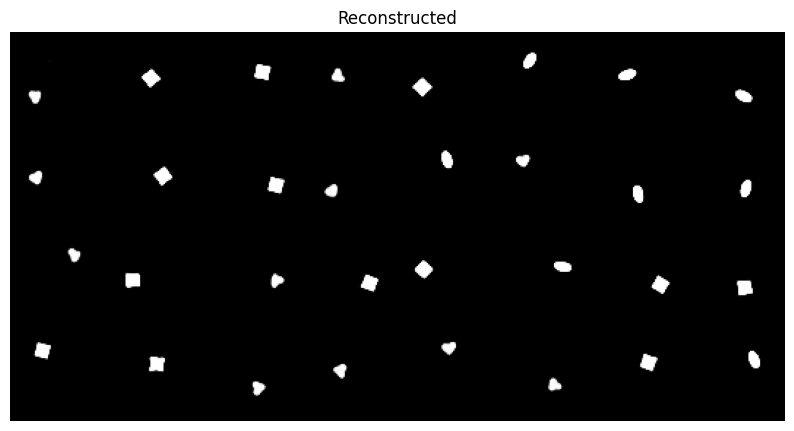

In [54]:
random_samples = random_sample_data(selected_dSprites_images, n_samples=32).cpu()
reconstructed_samples = s_vae_model.reconstructed_samples(random_samples, device='cpu').cpu()


plot_tensor_grid("original", random_samples,  n_cols=8, figsize=(10, 10), show_axis=False)
plot_tensor_grid("Reconstructed", reconstructed_samples, n_cols=8, figsize=(10, 10), show_axis=False)

In [80]:
# Use the following command to run tensorboard on the remote server (comment it if you do not want to run tensorboard)
! tensorboard --logdir lightning_logs --bind_all

2024-10-07 20:16:14.385197: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 20:16:14.385250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 20:16:14.386246: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 20:16:14.391567: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 20:16:15.130448: W tensorflow/compiler/tf2